# package and data loading

In [1]:
#packages for data handling
import anndata as ad
import pandas as pd

#computations
import numpy as np

#downsampling
import scanpy as sc

#visualization
import seaborn as sb
import matplotlib.pyplot as plt

# imports

In [2]:
adata_mc = ad.read_h5ad('../data/daniocell2023_gastrulation.metacells.h5ad')
print(f"{adata_mc.n_obs} metacells, {adata_mc.n_vars} genes")

adata_cells_raw = ad.read_h5ad('../data/daniocell2023_gastrulation.cells.h5ad')
adata_cells_raw.X = adata_cells_raw.X.toarray()
print(f"{adata_cells_raw.n_obs} cells, {adata_cells_raw.n_vars} genes")

selected_genes_mask = adata_cells_raw.var['selected_gene']
print(f'{len(adata_cells_raw.var_names[selected_genes_mask])} selected genes')

df_cell_to_cluster_scvi = pd.read_csv('../data/cells_cluster_data.csv')
df_cell_to_cluster_scvi.index = df_cell_to_cluster_scvi['cell']
df_cell_to_cluster_scvi.drop(columns=['cell'],inplace=True)

1010 metacells, 28833 genes
35705 cells, 28833 genes
3442 selected genes


# data preperation

In [3]:
scmat_dense = adata_cells_raw.X
scmat_dense = scmat_dense.transpose()
scmat_dense = pd.DataFrame(scmat_dense, 
                           index=adata_cells_raw.var_names.to_list(), 
                           columns=adata_cells_raw.obs_names)
count_sum = np.sum(scmat_dense, axis=0)
for n in np.quantile(count_sum,q=[0,.25,.5,.75,1]):
    print(n)

1000.0
2818.0
4313.0
6511.0
14024.0


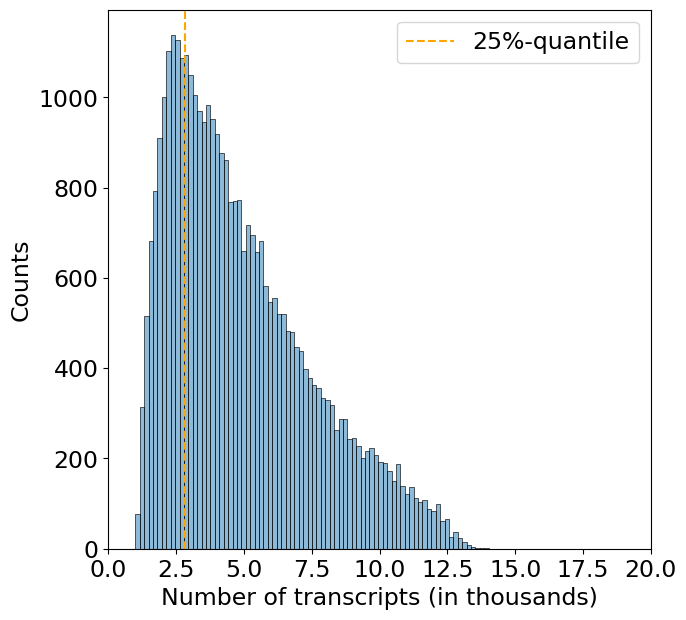

In [4]:
plt.figure(figsize=(7,7))

sb.histplot(count_sum/1000, 
                 bins=80, 
                 alpha=.5)
plt.axvline(np.quantile(count_sum, .25)/1000, 
            color='orange',
            linestyle='dashed', 
            label=r'25%-quantile')

plt.xticks(np.arange(0,22.5,2.5),fontsize=17)
plt.xlabel('Number of transcripts (in thousands)', fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Counts', fontsize=17)

plt.legend(fontsize=17)

plt.show()

## downsampling

### for each cell: downsample counts to 2800

In [5]:
adata_cells = adata_cells_raw.copy()
sc.pp.downsample_counts(adata_cells, 
                        counts_per_cell=2800,
                        random_state=42)

### remove cells with less than 2800 counts

In [6]:
tmp_sum = np.sum(adata_cells.X, axis=1)
mask = [(n == 2800) for n in tmp_sum]
print(f'removing {mask.count(False)} cells with less than 2800 UMIs')

scmat_ds = (adata_cells.X)[mask]
scmat_ds = scmat_ds.transpose()
scmat_ds = pd.DataFrame(scmat_ds, 
                        index=adata_cells.var_names.to_list(), 
                        columns=adata_cells[mask].obs_names)

removing 8793 cells with less than 2800 UMIs


## selecting genes

In [7]:
np.unique(adata_cells_raw[0,:].X != 0, return_counts=True)

(array([False,  True]), array([25530,  3303]))

In [8]:
full_prepro = adata_cells.copy()
full_prepro = adata_cells[:,selected_genes_mask]
full_prepro.obs = full_prepro.obs[['metacell',
                                   'metacell_name']]
full_prepro.obs['scvi_cluster'] = df_cell_to_cluster_scvi['predicted_cluster']

## function definitions

### calculate overdispersion (mean, variance) for every cluster

parameters
- adata (AnnData): AnnData object including clustering information in .obs
- clustering_colname (str/[str]): column name with clustering info in adata.obs
- size_threshold=10 (uint): minimal number of cells within a cluster (drop clusters with less number of cells)
- expr_threshold=1e-4 (float/double): minimum expression for genes to be included in the calculation (log2, normalized to 1 within each gene)
- output_variance=False (bool): include the variance in the output array

returns
- if output_variance == True: numpy array with the mean overdispersion value for every cluster
- if output_variance == False: numpy array with two rows, first holds overdispersion values means, second holds overdispersion values variances

In [9]:
def calculate_overdisp_means(adata, clustering_colname, size_threshold=10, expr_threshold=1e-4, output_variance=False):
    
    #clusters with sufficient size
    _large_clusters = np.array([item[0] for item in adata.obs[clustering_colname].value_counts().items() if item[1] >= size_threshold])
    
    #output array
    if(output_variance):
        _overdispersion_means = np.zeros((2, len(_large_clusters)))
    else:
        _overdispersion_means = np.zeros(len(_large_clusters))
    _cluster_counter = 0

    #iterate over every large cluster
    for cluster in _large_clusters:
        #create temporary subset
        _cluster_subset = adata.X[adata.obs[clustering_colname] == cluster]

        #normalized gene expression sums per gene
        _norm_expr_sum = np.log2((_cluster_subset.T / _cluster_subset.sum(axis=1)).T.sum(axis=0) + 1e-5)
        _true_index = np.where(_norm_expr_sum > np.log2(expr_threshold))[0]
        
        #compute overdispersion (var / mean) for every selected gene
        _var = np.var(_cluster_subset[:,_true_index], axis=0)
        _mean = np.mean(_cluster_subset[:,_true_index], axis=0)
        _overdisp = _var / _mean

        #calculate mean over all overdispersion rates
        if(output_variance):
            _overdispersion_means[0][_cluster_counter] = np.mean(_overdisp)
            _overdispersion_means[1][_cluster_counter] = np.var(_overdisp)
        else:
            _overdispersion_means[_cluster_counter] = np.mean(_overdisp)
        _cluster_counter += 1
        
    return _overdispersion_means

### calculate overdispersion for specific gene

parameters
- adata (AnnData): AnnData object including clustering information in .obs
- clustering_colname (str): column name with clustering info in adata.obs
- gene (str): gene name for overdispersion calculation
- size_threshold=10 (uint): minimal number of cells within a cluster (drop clusters with less number of cells)
- expr_threshold=8e-3 (float/double): minimum expression for genes to be included in the calculation (log2, normalized to 1 within each gene)

returns
- numpy array overdispersion values for selected gene

In [10]:
def calculate_overdisp_genes(adata, clustering_colname, gene, size_threshold=10, expr_threshold=8e-3):
    
    #list of clusters with sufficient size
    _large_clusters = np.array([item[0] for item in adata.obs[clustering_colname].value_counts().items() if item[1] >= size_threshold])    
    
    #output array
    overdispersion_output = np.zeros(len(_large_clusters))
    _cluster_counter = 0
    
    #iterate over every large cluster with high enough expression
    for cluster in _large_clusters:
        #create temporary subset
        _cluster_subset = adata.X[adata.obs[clustering_colname] == cluster]#, adata.var.index == gene]
        
        #normalized gene expression sums per gene
        _norm_expr_sum = np.log2((_cluster_subset.T / _cluster_subset.sum(axis=1)).T.sum(axis=0) + 1e-5)
        if (_norm_expr_sum[adata.var.index == gene] < np.log2(expr_threshold)):
            continue
            
        _tmp_var = np.var(_cluster_subset[:,adata.var.index == gene])
        _tmp_mean = np.mean(_cluster_subset[:,adata.var.index == gene])
        overdispersion_output[_cluster_counter] = _tmp_var / _tmp_mean
        
        _cluster_counter += 1
        
    return overdispersion_output[overdispersion_output != 0]

# Plotting results

## overdispersion over all clusters

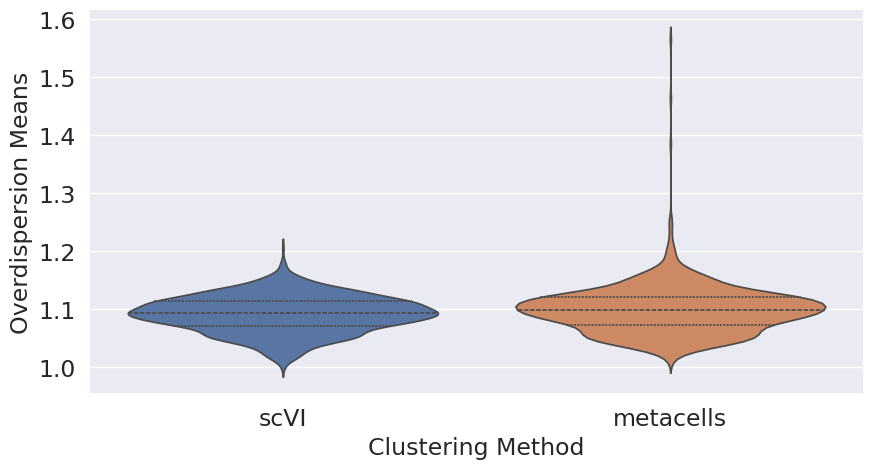

In [11]:
sb.set_theme()

plt.figure(figsize=(10, 5))

overdispersion_scvi = calculate_overdisp_means(full_prepro, 'scvi_cluster', size_threshold=10, expr_threshold=1e-4)
overdispersion_mc = calculate_overdisp_means(full_prepro, 'metacell', size_threshold=10, expr_threshold=1e-4)

df = pd.DataFrame({
    "Method": ["scVI"] * len(overdispersion_scvi) + ["metacells"] * len(overdispersion_mc),
    "Overdispersion": np.concatenate([overdispersion_scvi, overdispersion_mc]),
    "Color": ['Tableau Blue'] * len(overdispersion_scvi) + ['Tableau Orange'] * len(overdispersion_mc)
})

sb.violinplot(x="Method", y="Overdispersion", data=df, inner="quart", alpha=1, hue="Color", legend=False)

# annotations
plt.xticks([0,1], labels=['scVI', 'metacells'], fontsize=17)
plt.xlabel("Clustering Method", fontsize=17)
plt.ylabel("Overdispersion Means", fontsize=17)
plt.yticks(fontsize=17)

ax = plt.gca()
ax.xaxis.grid(False)

plt.savefig('../figures/overdispersion/scVI_mc_overdispersion_violin',dpi=300, bbox_inches='tight')
plt.show()

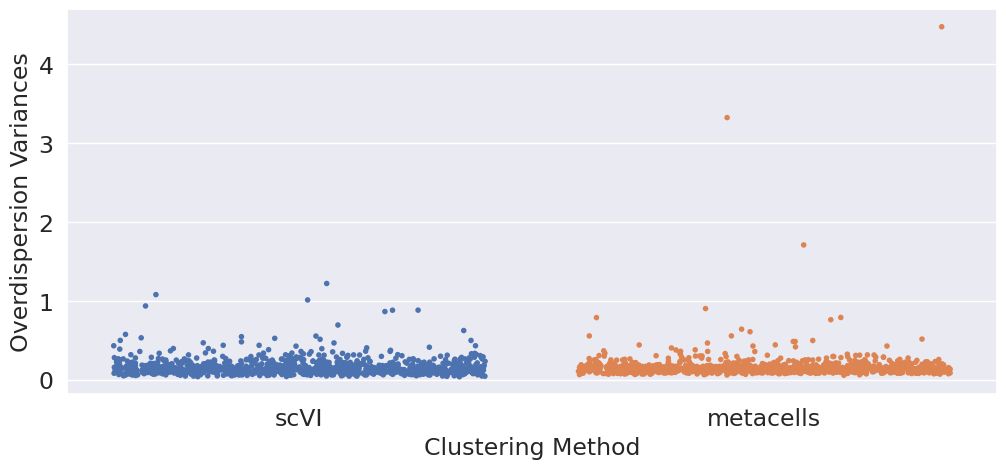

In [12]:
sb.set_theme()

plt.figure(figsize=(12, 5))

overdispersion_scvi = calculate_overdisp_means(full_prepro, 'scvi_cluster', size_threshold=10, expr_threshold=1e-4, output_variance=1)
overdispersion_mc = calculate_overdisp_means(full_prepro, 'metacell', size_threshold=10, expr_threshold=1e-4, output_variance=1)

sb.stripplot([overdispersion_scvi[1], overdispersion_mc[1]], size=4, jitter=.4)

# annotations
plt.xticks([0,1], labels=['scVI', 'metacells'], fontsize=17)
plt.xlabel("Clustering Method", fontsize=17)
plt.ylabel("Overdispersion Variances", fontsize=17)
plt.yticks(fontsize=17)

ax = plt.gca()
ax.xaxis.grid(False)

plt.savefig('../figures/overdispersion/scVI_mc_overdispersion_var_scatter',dpi=300, bbox_inches='tight')
plt.show()

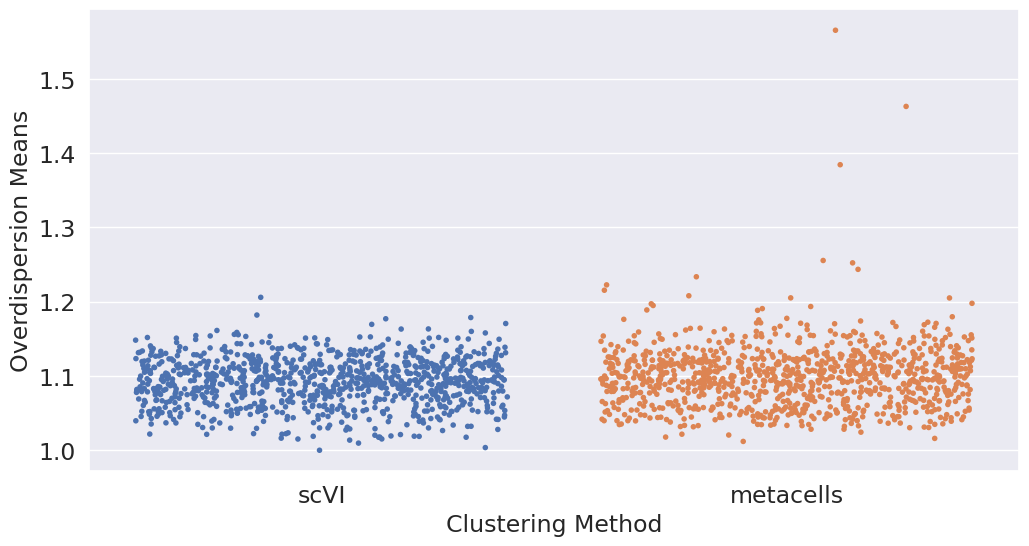

In [13]:
plt.figure(figsize=(12,6))

sb.stripplot([overdispersion_scvi[0], overdispersion_mc[0]], size=4, jitter=.4)

#annotations
plt.xticks([0,1], labels=['scVI', 'metacells'], fontsize=17)
plt.xlabel("Clustering Method", fontsize=17)
plt.ylabel("Overdispersion Means", fontsize=17)
plt.yticks(fontsize=17)

plt.savefig('../figures/overdispersion/scVI_mc_overdispersion_mean_scatter',dpi=300, bbox_inches='tight')
plt.show()

## Outlier genes overdispersion

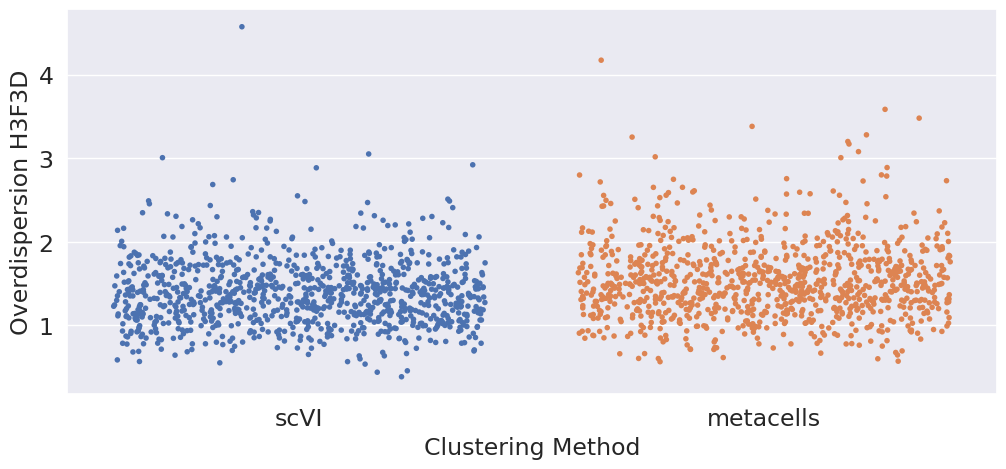

In [14]:
sb.set_theme()

plt.figure(figsize=(12, 5))

overdispersion_scvi_gene = calculate_overdisp_genes(full_prepro, 'scvi_cluster', 'H3F3D', size_threshold=10, expr_threshold=1e-3)
overdispersion_mc_gene = calculate_overdisp_genes(full_prepro, 'metacell', 'H3F3D', size_threshold=10, expr_threshold=1e-3)

sb.stripplot([overdispersion_scvi_gene, overdispersion_mc_gene], size=4, jitter=.4)

# annotations
plt.xticks([0,1], labels=['scVI', 'metacells'], fontsize=17)
plt.xlabel("Clustering Method", fontsize=17)
plt.ylabel("Overdispersion H3F3D", fontsize=17)
plt.yticks(fontsize=17)

ax = plt.gca()
ax.xaxis.grid(False)

plt.savefig('../figures/overdispersion/scVI_mc_overdispersion_h3f3d_scatter',dpi=300, bbox_inches='tight')
plt.show()

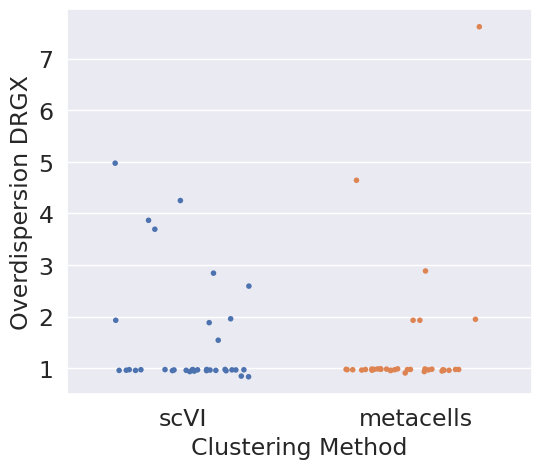

In [15]:
sb.set_theme()

plt.figure(figsize=(6, 5))

overdispersion_scvi_gene = calculate_overdisp_genes(full_prepro, 'scvi_cluster', 'DRGX', size_threshold=10, expr_threshold=1e-4)
overdispersion_mc_gene = calculate_overdisp_genes(full_prepro, 'metacell', 'DRGX', size_threshold=10, expr_threshold=1e-4)

sb.stripplot([overdispersion_scvi_gene, overdispersion_mc_gene], size=4, jitter=.3)

# annotations
plt.xticks([0,1], labels=['scVI', 'metacells'], fontsize=17)
plt.xlabel("Clustering Method", fontsize=17)
plt.ylabel("Overdispersion DRGX", fontsize=17)
plt.yticks(fontsize=17)

ax = plt.gca()
ax.xaxis.grid(False)

plt.savefig('../figures/overdispersion/scVI_mc_overdispersion_drgx_scatter',dpi=300, bbox_inches='tight')
plt.show()

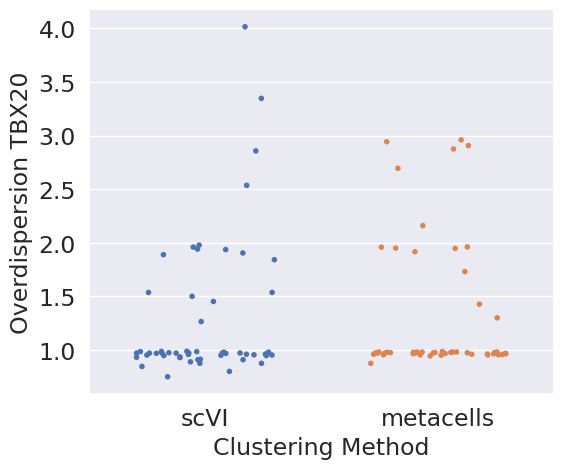

In [16]:
sb.set_theme()

plt.figure(figsize=(6, 5))

overdispersion_scvi_gene = calculate_overdisp_genes(full_prepro, 'scvi_cluster', 'TBX20', size_threshold=10, expr_threshold=1e-4)
overdispersion_mc_gene = calculate_overdisp_genes(full_prepro, 'metacell', 'TBX20', size_threshold=10, expr_threshold=1e-4)

sb.stripplot([overdispersion_scvi_gene, overdispersion_mc_gene], size=4, jitter=.3)

# annotations
plt.xticks([0,1], labels=['scVI', 'metacells'], fontsize=17)
plt.xlabel("Clustering Method", fontsize=17)
plt.ylabel("Overdispersion TBX20", fontsize=17)
plt.yticks(fontsize=17)

ax = plt.gca()
ax.xaxis.grid(False)

plt.savefig('../figures/overdispersion/scVI_mc_overdispersion_tbx20_scatter',dpi=300, bbox_inches='tight')
plt.show()

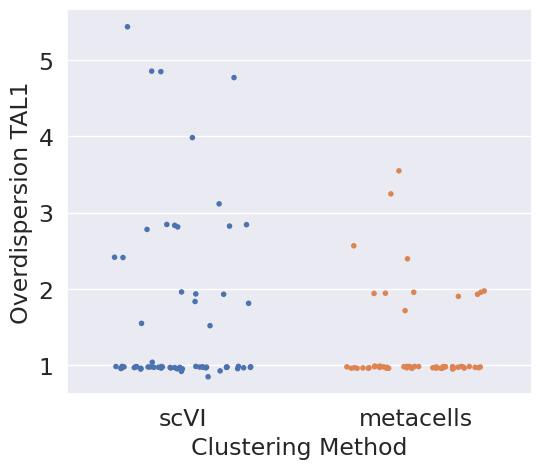

In [17]:
sb.set_theme()

plt.figure(figsize=(6, 5))

overdispersion_scvi_gene = calculate_overdisp_genes(full_prepro, 'scvi_cluster', 'TAL1', size_threshold=10, expr_threshold=1e-4)
overdispersion_mc_gene = calculate_overdisp_genes(full_prepro, 'metacell', 'TAL1', size_threshold=10, expr_threshold=1e-4)

sb.stripplot([overdispersion_scvi_gene, overdispersion_mc_gene], size=4, jitter=.3)

# annotations
plt.xticks([0,1], labels=['scVI', 'metacells'], fontsize=17)
plt.xlabel("Clustering Method", fontsize=17)
plt.ylabel("Overdispersion TAL1", fontsize=17)
plt.yticks(fontsize=17)

ax = plt.gca()
ax.xaxis.grid(False)

plt.savefig('../figures/overdispersion/scVI_mc_overdispersion_tal1_scatter',dpi=300, bbox_inches='tight')
plt.show()